<a href="https://colab.research.google.com/github/sneha1012/knowledge-graph-completion/blob/main/Knowlegegraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
%cd /content/drive/My Drive/Data for GATS


/content/drive/My Drive/Data for GATS


In [16]:
!ls


'MSR-LA_Data_Full Rights_FB15K-237 Knowledge Base Completion Dataset (2650).docx'
 README.txt
 test.txt
 text_cvsc.txt
 text_emnlp.txt
 train.txt
 valid.txt


In [18]:
!git clone https://github.com/gordicaleksa/pytorch-GAT.git
%cd pytorch-GAT
!rm -rf .git


Cloning into 'pytorch-GAT'...
remote: Enumerating objects: 634, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 634 (delta 135), reused 128 (delta 128), pack-reused 490
Receiving objects: 100% (634/634), 24.23 MiB | 11.10 MiB/s, done.
Resolving deltas: 100% (345/345), done.
/content/drive/My Drive/Data for GATS/pytorch-GAT/pytorch-GAT


converting Entities and relations to unique integers

In [21]:
!pwd


/content/drive/MyDrive/Data for GATS/pytorch-GAT/pytorch-GAT


In [22]:
!ls


 data		   playground.py		     training_script_cora.py
 environment.yml   README.md			     training_script_ppi.py
 LICENCE	  'The Annotated GAT (Cora).ipynb'   utils
 models		  'The Annotated GAT (PPI).ipynb'


In [23]:
%cd /content/drive/My Drive
!find . -name "train.txt"


/content/drive/My Drive
./Data for GATS/train.txt


In [24]:
%cd /content/drive/My Drive/Data for GATS/


/content/drive/My Drive/Data for GATS


In [25]:
!ls


'MSR-LA_Data_Full Rights_FB15K-237 Knowledge Base Completion Dataset (2650).docx'
 pytorch-GAT
 README.txt
 test.txt
 text_cvsc.txt
 text_emnlp.txt
 train.txt
 valid.txt


In [28]:
file_path = '/content/drive/My Drive/Data for GATS/train.txt'




In [29]:
import numpy as np

# Dictionaries to map entities and relations to unique integer IDs
entity2id = {}
relation2id = {}

# Lists to store triples
triples = []

# Read the file and process the data
with open(file_path, 'r') as f:
    for line in f:
        s, p, o = line.strip().split('\t')

        # Assign unique IDs to entities and relations
        if s not in entity2id:
            entity2id[s] = len(entity2id)
        if o not in entity2id:
            entity2id[o] = len(entity2id)
        if p not in relation2id:
            relation2id[p] = len(relation2id)

        # Store the triples
        triples.append((entity2id[s], relation2id[p], entity2id[o]))

# Generate initial random embeddings for entities
embedding_dim = 16  # Dimension of the embeddings
num_entities = len(entity2id)
initial_entity_embeddings = np.random.rand(num_entities, embedding_dim)

print(f"Number of unique entities: {num_entities}")
print(f"Number of unique relations: {len(relation2id)}")
print(f"Number of triples: {len(triples)}")
print(f"Sample initial embedding for the first entity: {initial_entity_embeddings[0]}")


Number of unique entities: 14505
Number of unique relations: 237
Number of triples: 272115
Sample initial embedding for the first entity: [0.29575273 0.49685077 0.14133008 0.18971445 0.01729154 0.8183854
 0.87481075 0.45563967 0.03511331 0.70896097 0.1443778  0.13706243
 0.33433446 0.9093752  0.17920775 0.46051634]


In [30]:
import torch.nn as nn

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GATLayer, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.fc(x)

class GAT(nn.Module):
    def __init__(self, in_features, out_features):
        super(GAT, self).__init__()
        self.layer1 = GATLayer(in_features, out_features)

    def forward(self, x):
        return self.layer1(x)

model = GAT(embedding_dim, embedding_dim)


Training the GAT Model on FB15k-237

In [34]:
#setting hyperparameters and loss function

import torch.optim as optim

learning_rate = 0.01
epochs = 10

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


In [33]:
import torch

# Convert the numpy ndarray to a PyTorch tensor
initial_entity_embeddings_tensor = torch.tensor(initial_entity_embeddings, dtype=torch.float32)

# Training the model
for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(initial_entity_embeddings_tensor)
    loss = criterion(outputs, initial_entity_embeddings_tensor)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")



Epoch 1/10, Loss: 0.43084439635276794
Epoch 2/10, Loss: 0.3472953736782074
Epoch 3/10, Loss: 0.27929767966270447
Epoch 4/10, Loss: 0.22614336013793945
Epoch 5/10, Loss: 0.18672850728034973
Epoch 6/10, Loss: 0.15932075679302216
Epoch 7/10, Loss: 0.14144457876682281
Epoch 8/10, Loss: 0.1303296983242035
Epoch 9/10, Loss: 0.123459592461586
Epoch 10/10, Loss: 0.11890795826911926


In [38]:
# Converting the numpy ndarray to a PyTorch tensor
initial_entity_embeddings_tensor = torch.tensor(initial_entity_embeddings, dtype=torch.float32)

# Getting  the embeddings from the first layer of the model
first_layer_embeddings = model.layer1(initial_entity_embeddings_tensor).detach().numpy()



In [37]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(first_layer_embeddings)


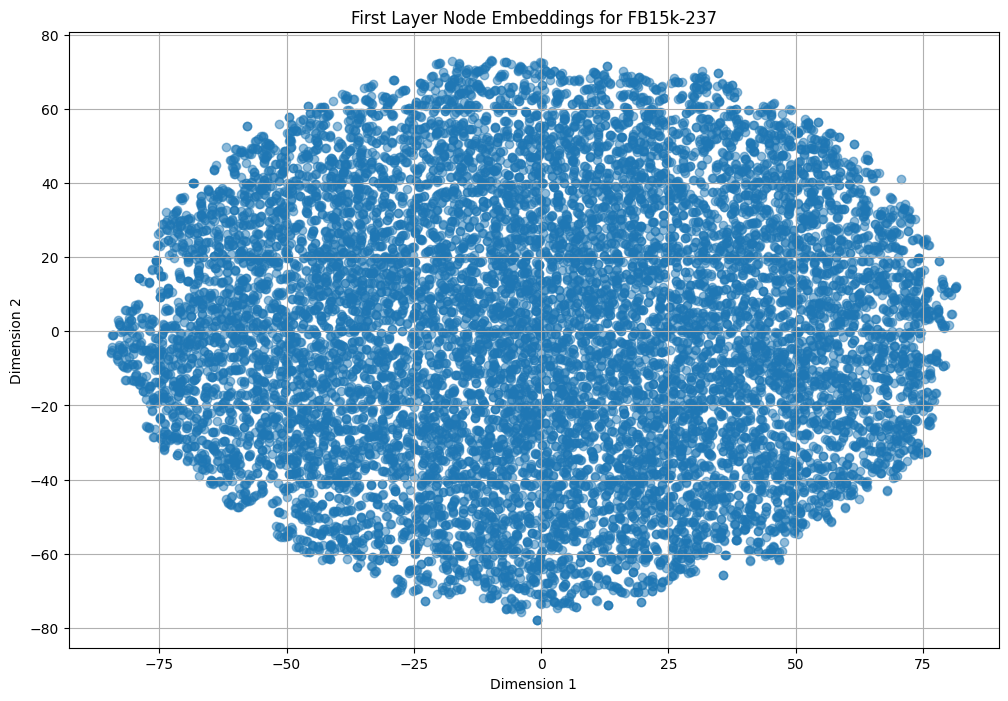

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
plt.title('First Layer Node Embeddings for FB15k-237')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

plt.show()


In [44]:
plt.savefig('plot_name.png')



<Figure size 640x480 with 0 Axes>

In [45]:
from google.colab import files

files.download('plot_name.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>